# Pipeline 2: DW-To-Google pipeline

The aim of this notebook is to be able to answer the questions: How timely are DW articles?

Approach: Extract importnat DW keywords, see how they fluctuate in time and compare to Google searches

<img src="../reports/illustrations/pipeline2.png" width=800 />

In [10]:
# Import useful libraries
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

# Import functions from source folder
sys.path.append('../src/') 
from data.preprocess_keywords import make_cleaned_keywords_df
from data.make_datasets import get_data, get_interest_over_time, get_dw_timeseries
from visualization.visualize import plot_signals
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
# Specify keyword of interest
keyword = 'angela merkel'

# Specify wanted time range
start_date = '2019-01-01'
end_date = '2022-01-01'

# Get google data for a specific keyword

In [4]:
google_df = get_interest_over_time(keyword, start_date, end_date)

/home/marios/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/marios/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/marios/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'trends.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/mari

# Load DW data

In [5]:
# Clean data file in specific date range
clean_data_file = '../data/interim/clean_keywords_' + start_date + '_' + end_date + '.json'

# Generates the clean data file if it does not exist
if os.path.isfile(clean_data_file) == False:

    # Path to raw data
    data_file = '../data/raw/CMS_2010_to_June_2022_ENGLISH.json'

    # Load and extract data within time range
    df_subset = get_data(data_file, start_date, end_date)

    # Cleans keywords and saves data as a dataframe
    make_cleaned_keywords_df(df_subset, start_date, end_date)


# Loads the clean data file
df_dw = pd.read_json(clean_data_file, orient ='split', compression = 'infer')

# Get DW mentions binned into the google dates output 
mixed_df = get_dw_timeseries(df_dw, keyword, google_df, start_date = start_date)

# Compare between DW trends for this keyword and Google

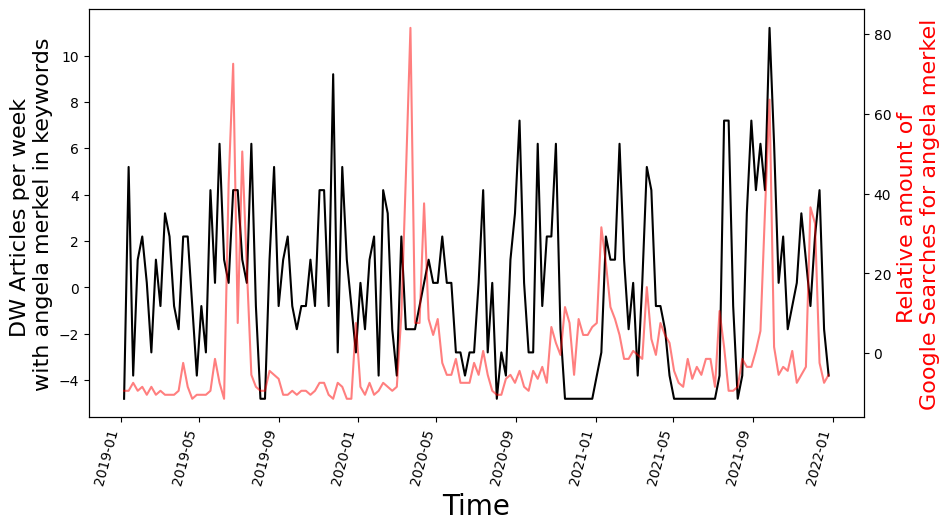

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

plot_signals(mixed_df, fig, ax, keyword)

In [7]:
#print dates with maximum number of articles published on topic 
#and date for maximum search interest
def maximum_interest(selected_keyword, df_plot):
    #google
    print('maximum interest in google for '+ selected_keyword + ' was on ')
    max_int_google=df_plot[df_plot['google']==df_plot['google'].max()]
    print(max_int_google.index[0])
    print(' ')
    #print(' ')
    #DW
    max_int_dw=df_plot[df_plot['dw']==df_plot['dw'].max()]
    print('maximum number of published articles in DW about '+ selected_keyword + ' was on ')
    print(max_int_dw.index[0])
    #print(' ')
    print(' ')
    delay=(max_int_dw.index-max_int_google.index)

    print('delay in publishing about this topic is '  )
    print(delay[0])


In [8]:
#print dates with maximum number of articles published on topic 
#and date for maximum search interest
maximum_interest(keyword,mixed_df)

maximum interest in google for angela merkel was on 
2020-03-22 00:00:00
 
maximum number of published articles in DW about angela merkel was on 
2021-09-26 00:00:00
 
delay in publishing about this topic is 
553 days 00:00:00


In [15]:
# calculating a potential delay in trend between the two signals
#granger causality
gc_res = grangercausalitytests(mixed_df, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3560  , p=0.5516  , df_denom=152, df_num=1
ssr based chi2 test:   chi2=0.3630  , p=0.5469  , df=1
likelihood ratio test: chi2=0.3626  , p=0.5471  , df=1
parameter F test:         F=0.3560  , p=0.5516  , df_denom=152, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8714  , p=0.4205  , df_denom=149, df_num=2
ssr based chi2 test:   chi2=1.8012  , p=0.4063  , df=2
likelihood ratio test: chi2=1.7907  , p=0.4085  , df=2
parameter F test:         F=0.8714  , p=0.4205  , df_denom=149, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2865  , p=0.8351  , df_denom=146, df_num=3
ssr based chi2 test:   chi2=0.9006  , p=0.8253  , df=3
likelihood ratio test: chi2=0.8980  , p=0.8259  , df=3
parameter F test:         F=0.2865  , p=0.8351  , df_denom=146, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2855  , p=0.8870  

In [11]:
#Calculating distance between two timesries: Dynamic Time warping
#The matrix with all warping paths can be visualised as follows: 
#!pip install dtaidistance
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
def dta(s1,s2):
    # s1 = detrended_dw
    # s2 = detrended_google
    x = np.arange(0, 20, .5)

    random.seed(1)
    for idx in range(len(s2)):
        if random.random() < 0.05:
            s2[idx] += (random.random() - 0.5) / 2
    d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
    best_path = dtw.best_path(paths)
    dtwvis.plot_warpingpaths(s1, s2, paths, best_path)
    return d

168.73956277095837

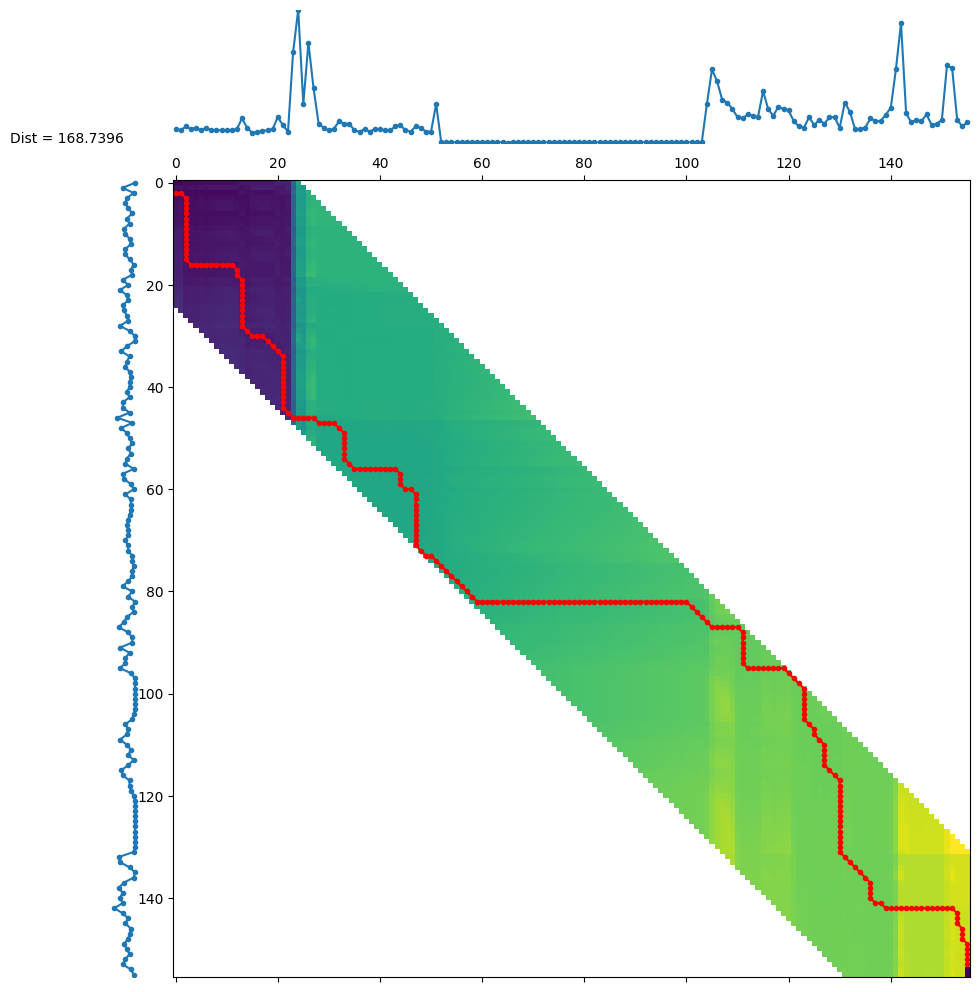

In [12]:
dta(mixed_df['dw'],mixed_df['google'])